# Momentum resolution

In the following, all measurements are in metres, resp. radians.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

## Tracking resolution

## Single trajectory (based on a reusable function out of it)

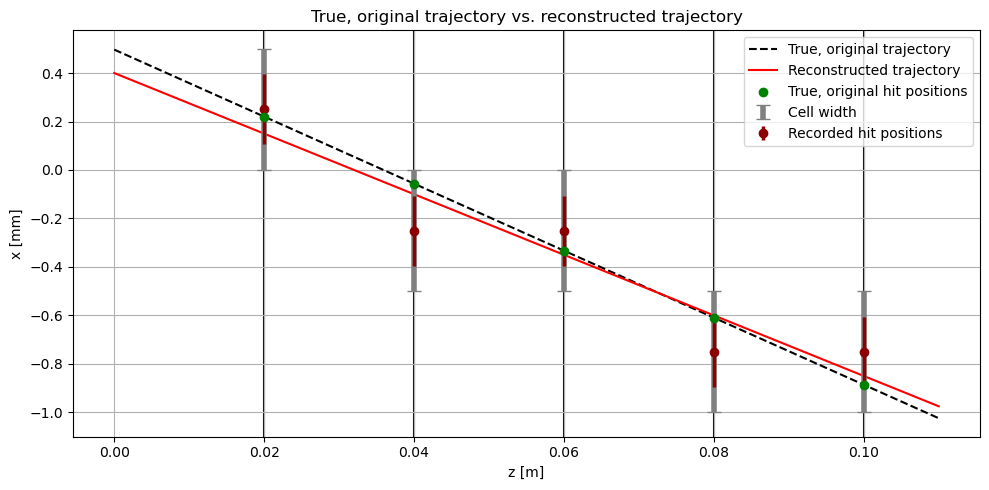

x0_true = 0.497 mm, s0_true = -0.014 rad
x0_reco = 0.400 mm ± 0.151 mm
s0_reco = -0.012 ± 0.002 rad


In [ ]:
# Calculate the z and x positions of the planes 
# To use curve_fit, we need to have a function defined, so we use a function to calculate the x_positions
def trajectory_fun(z_position, x0, angle): 
    return x0 + z_position * np.tan(angle) # Calculating the vertical position using trigonometry

def trajectory_fun_linear(z_position, x0, slope): 
    return x0 + z_position * slope # Calculating the vertical position using trigonometry

def single_trajectory(n_planes = 5, delta_z = 0.02, cell_width = 0.0005):
    x0_true = np.random.normal(0, 0.001)
    s0_true = np.random.normal(0, 0.1)

    slope_true = np.tan(s0_true)

    z_positions = np.arange(1, n_planes + 1) * delta_z
    x_positions = trajectory_fun_linear(z_positions, x0_true, slope_true) 

    # Calculate which cell was hit
    cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
    cells_hit_middle = cells_hit * cell_width + cell_width / 2

    # Add Gaussian noise to simulate measurement uncertainty (realistic detector resolution)
    # Increases the uncertainty a lot - maybe not what we want
    # cells_hit_middle += np.random.normal(0, std_hit, size=cells_hit_middle.shape)

    # Calculate the uncertainty
    std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia

    # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
    popt, pcov = curve_fit(trajectory_fun_linear, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

    x0_reco, slope_reco = popt
    std_x0_reco, std_slope_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)

    s0_reco = np.arctan(slope_reco)

    # We now do error propagation by using y = f(x) -> sigma_y = abs(df/dx (x_mean)) * sigma_x
    std_s0_reco = std_slope_reco / (1 + slope_reco**2) 

    return s0_true, s0_reco, std_s0_reco, x0_true, x0_reco, std_x0_reco, z_positions, x_positions, cells_hit_middle, std_hit

n_planes = 5
delta_z = 0.02  # 2 cm in metres
cell_width = 0.0005  # 500 micrometers in metres
z0 = 0

np.random.seed(42)

s0_true, s0_reco, std_s0_reco, x0_true, x0_reco, std_x0_reco, z_positions, x_positions, cells_hit_middle, std_hit = single_trajectory()

# Plotting
grid = np.linspace(0, z_positions[-1] + delta_z/2, num = 1001)
true_traj_z = trajectory_fun(grid, x0_true, s0_true)
reco_traj_z = trajectory_fun(grid, x0_reco, s0_reco)

plt.figure(figsize=(10,5))
for z in z_positions:
    plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0) # Detector planes
# I multiplied everything by thousand such that the y-axis has millimetre values
plt.plot(grid, 1000*true_traj_z, "k--", label = "True, original trajectory") 
plt.plot(grid, 1000*reco_traj_z, "r-", label = "Reconstructed trajectory")
plt.scatter(z_positions, 1000*x_positions, color = "g", label = "True, original hit positions", zorder = 3)
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*cell_width/2, fmt='none', color='grey', elinewidth=4, capsize=5, label="Cell width")
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*std_hit, fmt = "o", color = "darkred", linewidth = 2.5, label = "Recorded hit positions")

plt.xlabel("z [m]")
plt.ylabel("x [mm]")
plt.grid()
plt.legend()
plt.title("True, original trajectory vs. reconstructed trajectory")
plt.tight_layout()
# plt.savefig("Single trajectory")
plt.show()


print(f"x0_true = {x0_true*1000:.3f} mm, s0_true = {s0_true:.3f} rad")
print(f"x0_reco = {x0_reco*1000:.3f} mm ± {std_x0_reco*1000:.3f} mm")
print(f"s0_reco = {s0_reco:.3f} ± {std_s0_reco:.3f} rad")



## Multiple trajectories

We see that we account for too little uncertainty when looking at the pulls.

Reasons (if it was a real detector):
- No electronics noise simulated
- Detector misalignments (z positions cannot be exact)
- We modeled the uncertainty with /sqrt(12) - but we neglected the multiple scattering part. Important to mention this!

We see that especially the uncertainty of s0 is underestimated. This is because we're fitting s0 directly, but because tan(s0) is nonlinear, the impact of errors in s0 grows with s0, and your uncertainty model doesn’t fully capture that.

We first tried to model the uncertainty the direct way, but because of the comment above, the unlinearity of tan(s0) leads to an underestimation of the uncertainty of s0.

The pull distributions for x0 and s0 have standard deviations of 1.033 (1.052 for 10000) and 1.082 (1.126 for 10000), respectively, indicating that the uncertainties from the fit are well estimated, though slightly underestimated, particularly for the angle. This is within acceptable bounds and may be attributed to the use of discrete cell-based hit positions and idealized assumptions such as perfect detector alignment and no noise. Overall, the model shows consistent, unbiased reconstruction. (ChatGPT)

#### New Code (adding nonlinearity after finding the estimates of the standard deviation of the linear slope and using function for single trajectory)

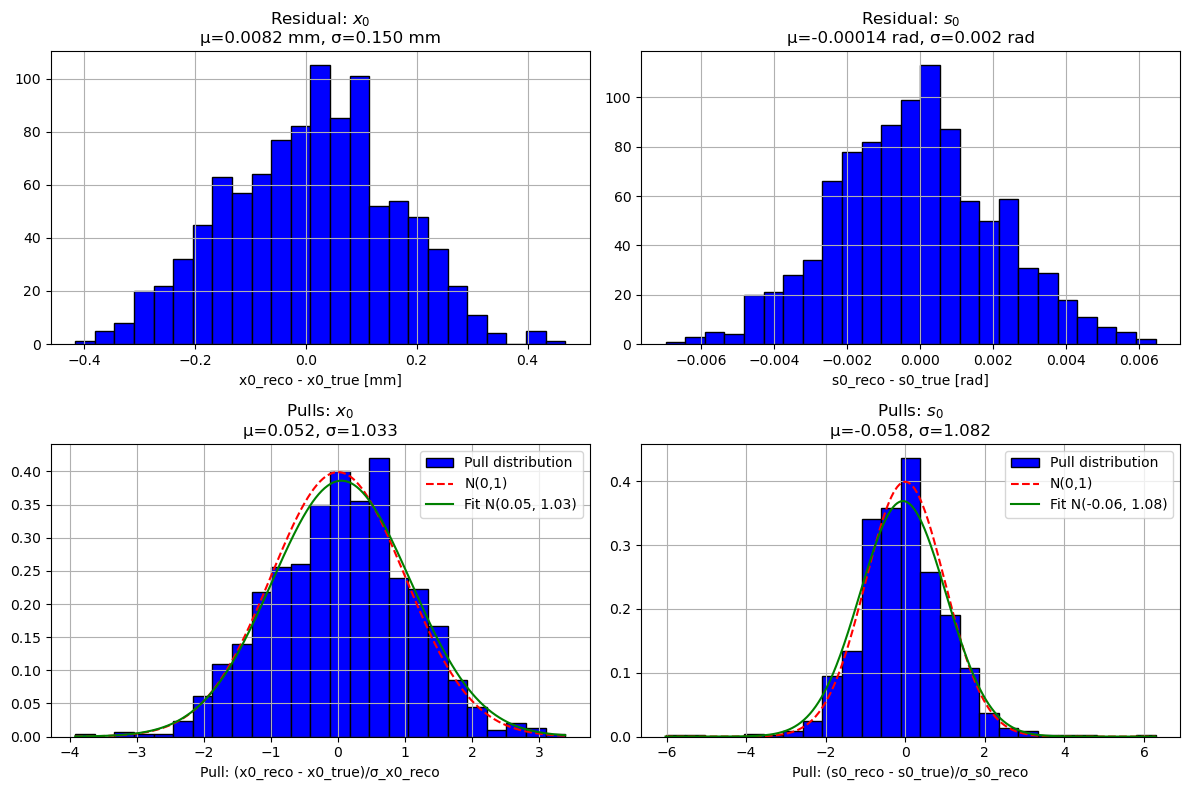

In [ ]:
n_trajectories = 1000
z0 = 0
delta_z = 0.02  # 2 cm in metres
n_planes = 5
cell_width = 0.0005  # 500 micrometers in metres


np.random.seed(42)

# Arrays for the residuals and for the pulls
resi_s0 = np.full(n_trajectories, np.nan)
resi_x0 = np.full(n_trajectories, np.nan)

pulls_s0 = np.full(n_trajectories, np.nan)
pulls_x0 = np.full(n_trajectories, np.nan)

for i in range(n_trajectories):
    s0_true, s0_reco, std_s0_reco, x0_true, x0_reco, std_x0_reco, z_positions, x_positions, cells_hit_middle, std_hit = single_trajectory()

    # Residuals
    resi_s0[i] = s0_reco - s0_true
    resi_x0[i] = x0_reco - x0_true

    # pull = (reconstructed_quantity - generated_quantity)/uncertainty_on_reconstructed_quantity
    pulls_s0[i] = (s0_reco - s0_true)/std_s0_reco
    pulls_x0[i] = (x0_reco - x0_true)/std_x0_reco


# Taking the mean and standard deviation for the residuals
mean_resi_s0 = np.mean(resi_s0)
mean_resi_x0 = np.mean(resi_x0)

std_resi_s0 = np.std(resi_s0)
std_resi_x0 = np.std(resi_x0)

# 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot these distributions as histograms
axs[0, 0].hist(resi_x0 * 1000, bins = 25, color = "blue", edgecolor = "black")
axs[0, 0].set_title(f"Residual: $x_0$\nμ={mean_resi_x0 * 1000:.4f} mm, σ={std_resi_x0 * 1000:.3f} mm")
axs[0, 0].set_xlabel("x0_reco - x0_true [mm]")
axs[0, 0].grid()

axs[0, 1].hist(resi_s0, bins = 25, color = "blue", edgecolor = "black")
axs[0, 1].set_title(f"Residual: $s_0$\nμ={mean_resi_s0:.5f} rad, σ={std_resi_s0:.3f} rad")
axs[0, 1].set_xlabel("s0_reco - s0_true [rad]")
axs[0, 1].grid()


# Taking the mean and standard deviation for the pulls
mean_pulls_s0 = np.mean(pulls_s0)
mean_pulls_x0 = np.mean(pulls_x0)

std_pulls_s0 = np.std(pulls_s0)
std_pulls_x0 = np.std(pulls_x0)

# Plot these distributions as histograms
"""
plt.figure()
plt.hist(pulls_x0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $x_0$, μ={mean_pulls_x0:.3f}, σ={std_pulls_x0: .3f}")
plt.xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
plt.grid()
plt.show()

plt.figure()
plt.hist(pulls_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $s_0$, μ={mean_pulls_s0:.3f}, σ={std_pulls_s0: .3f}")
plt.xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
plt.grid()
plt.show()
"""

# Plot the distributions exactly the same way again, now with overlayed Gaussian distributions
axs[1, 0].hist(pulls_x0, bins=25, density=True, color="blue", edgecolor="black", label="Pull distribution")
x_vals = np.linspace(min(pulls_x0), max(pulls_x0), 500)
axs[1, 0].plot(x_vals, norm.pdf(x_vals, 0, 1), 'r--', label="N(0,1)")
axs[1, 0].plot(x_vals, norm.pdf(x_vals, mean_pulls_x0, std_pulls_x0), 'g-', label=f"Fit N({mean_pulls_x0:.2f}, {std_pulls_x0:.2f})")
axs[1, 0].set_title(f"Pulls: $x_0$\nμ={mean_pulls_x0:.3f}, σ={std_pulls_x0:.3f}")
axs[1, 0].set_xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].hist(pulls_s0, bins=25, density=True, color="blue", edgecolor="black", label="Pull distribution")
x_vals = np.linspace(min(pulls_s0), max(pulls_s0), 500)
axs[1, 1].plot(x_vals, norm.pdf(x_vals, 0, 1), 'r--', label="N(0,1)")
axs[1, 1].plot(x_vals, norm.pdf(x_vals, mean_pulls_s0, std_pulls_s0), 'g-', label=f"Fit N({mean_pulls_s0:.2f}, {std_pulls_s0:.2f})")
axs[1, 1].set_title(f"Pulls: $s_0$\nμ={mean_pulls_s0:.3f}, σ={std_pulls_s0:.3f}")
axs[1, 1].set_xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
axs[1, 1].legend()
axs[1, 1].grid()

plt.tight_layout()
# plt.savefig("Multiple trajectories")
plt.show()
    

# Old code (for report reasons still here, but please: do NOT use)

## Single trajectory

### Old version: Single trajectory (without making a function out of it)

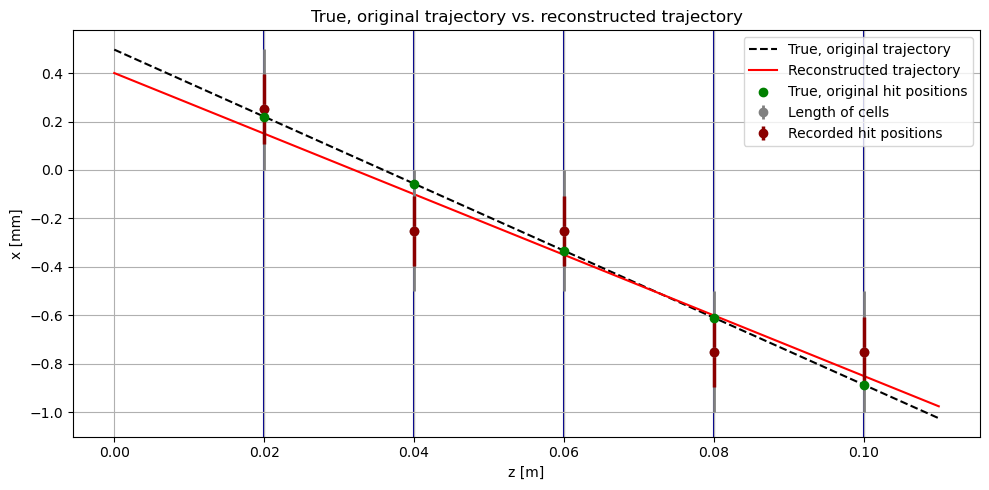

x0_true = 0.497 mm, s0_true = -0.014 rad
x0_reco = 0.400 mm ± 0.151 mm
s0_reco = -0.012 ± 0.002 rad


In [5]:
# OLD VERSION

n_planes = 5
delta_z = 0.02  # 2 cm in metres
cell_width = 0.0005  # 500 micrometers in metres

np.random.seed(42)

x0_true = np.random.normal(0, 0.001)
s0_true = np.random.normal(0, 0.1)

z0 = 0

# Calculate the z and x positions of the planes 
# To use curve_fit, we need to have a function defined, so we use a function to calculate the x_positions
def trajectory_fun(z_position, x0, angle): 
    return x0 + z_position * np.tan(angle) # Calculating the vertical position using trigonometry

z_positions = np.arange(1, n_planes + 1) * delta_z
x_positions = trajectory_fun(z_positions, x0_true, s0_true)

# Calculate which cell was hit
cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
cells_hit_middle = cells_hit * cell_width + cell_width / 2

# Calculate the uncertainty
std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia
# Missing influence of the uncertainty of the spread of the slope/angle ???



# Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
popt, pcov = curve_fit(trajectory_fun, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

x0_reco, s0_reco = popt
std_x0_reco, std_s0_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)


# Plotting
grid = np.linspace(0, z_positions[-1] + delta_z/2, num = 1001)
true_traj_z = trajectory_fun(grid, x0_true, s0_true)
reco_traj_z = trajectory_fun(grid, x0_reco, s0_reco)

plt.figure(figsize=(10,5))
for z in z_positions:
    plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0) # Detector planes
# I multiplied everything by thousand such that the y-axis has millimetre values
plt.plot(grid, 1000*true_traj_z, "k--", label = "True, original trajectory") 
plt.plot(grid, 1000*reco_traj_z, "r-", label = "Reconstructed trajectory")
plt.scatter(z_positions, 1000*x_positions, color = "g", label = "True, original hit positions", zorder = 3)
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*cell_width/2, fmt = "o", color = "grey", linewidth = 2, label = "Length of cells")
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*std_hit, fmt = "o", color = "darkred", linewidth = 2.5, label = "Recorded hit positions")

plt.xlabel("z [m]")
plt.ylabel("x [mm]")
plt.grid()
plt.legend()
plt.title("True, original trajectory vs. reconstructed trajectory")
plt.tight_layout()
plt.show()


print(f"x0_true = {x0_true*1000:.3f} mm, s0_true = {s0_true:.3f} rad")
print(f"x0_reco = {x0_reco*1000:.3f} mm ± {std_x0_reco*1000:.3f} mm")
print(f"s0_reco = {s0_reco:.3f} ± {std_s0_reco:.3f} rad")



## Multiple trajectories

#### Old Code (including nonlinearity when finding the estimates of the standard deviation)

C:\Users\flori\AppData\Local\Temp\ipykernel_6712\3970654156.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(trajectory_fun, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)


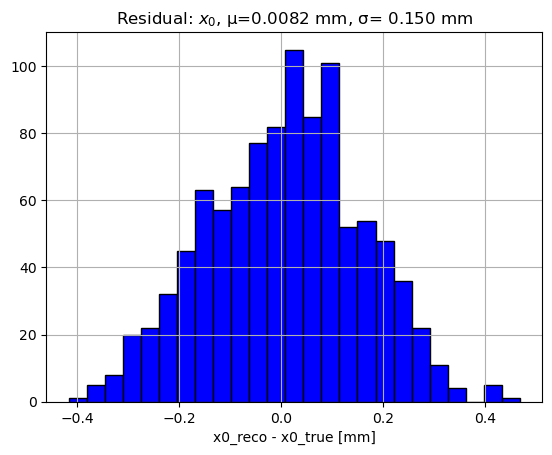

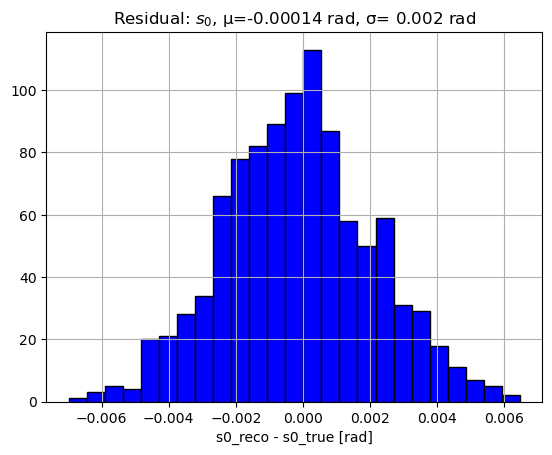

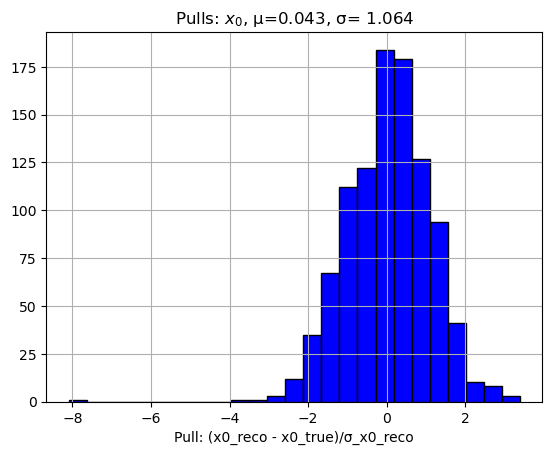

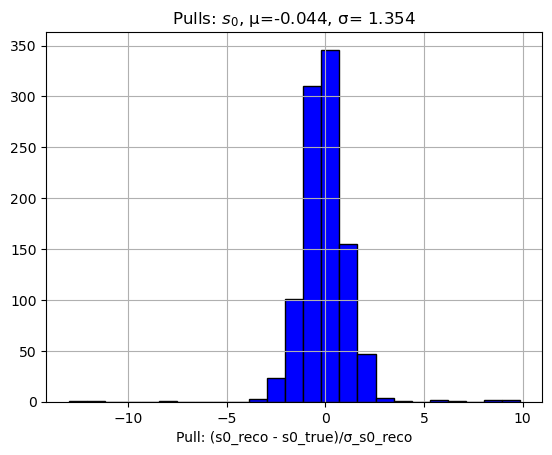

In [6]:
# OLD CODE, ONLY FOR ANALYSIS LATER ON, PLEASE DON'T USE ANYMORE

n_trajectories = 1000
z0 = 0
delta_z = 0.02  # 2 cm in metres
n_planes = 5
cell_width = 0.0005  # 500 micrometers in metres

# Calculate the uncertainty
std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia

z_positions = np.arange(1, n_planes + 1) * delta_z

np.random.seed(42)

# Arrays for the residuals and for the pulls
resi_s0 = np.full(n_trajectories, np.nan)
resi_x0 = np.full(n_trajectories, np.nan)

pulls_s0 = np.full(n_trajectories, np.nan)
pulls_x0 = np.full(n_trajectories, np.nan)

for i in range(n_trajectories):
    x0_true = np.random.normal(0, 0.001)
    s0_true = np.random.normal(0, 0.1)

    x_positions = trajectory_fun(z_positions, x0_true, s0_true) 

    # Calculate which cell was hit
    cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
    cells_hit_middle = cells_hit * cell_width + cell_width / 2

    # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
    popt, pcov = curve_fit(trajectory_fun, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

    x0_reco, s0_reco = popt
    std_x0_reco, std_s0_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)

    resi_s0[i] = s0_reco - s0_true
    resi_x0[i] = x0_reco - x0_true

    # pull = (reconstructed_quantity - generated_quantity)/uncertainty_on_reconstructed_quantity
    pulls_s0[i] = (s0_reco - s0_true)/std_s0_reco
    pulls_x0[i] = (x0_reco - x0_true)/std_x0_reco


# Taking the mean and standard deviation for the residuals
mean_resi_s0 = np.mean(resi_s0)
mean_resi_x0 = np.mean(resi_x0)

std_resi_s0 = np.std(resi_s0)
std_resi_x0 = np.std(resi_x0)


# Plot these distributions as histograms
plt.figure()
plt.hist(resi_x0 * 1000, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $x_0$, μ={mean_resi_x0 * 1000:.4f} mm, σ={std_resi_x0 * 1000: .3f} mm")
plt.xlabel("x0_reco - x0_true [mm]")
plt.grid()
plt.show()

plt.figure()
plt.hist(resi_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $s_0$, μ={mean_resi_s0:.5f} rad, σ={std_resi_s0: .3f} rad")
plt.xlabel("s0_reco - s0_true [rad]")
plt.grid()
plt.show()


# Taking the mean and standard deviation for the pulls
mean_pulls_s0 = np.mean(pulls_s0)
mean_pulls_x0 = np.mean(pulls_x0)

std_pulls_s0 = np.std(pulls_s0)
std_pulls_x0 = np.std(pulls_x0)

# Plot these distributions as histograms
plt.figure()
plt.hist(pulls_x0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $x_0$, μ={mean_pulls_x0:.3f}, σ={std_pulls_x0: .3f}")
plt.xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
plt.grid()
plt.show()

plt.figure()
plt.hist(pulls_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $s_0$, μ={mean_pulls_s0:.3f}, σ={std_pulls_s0: .3f}")
plt.xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
plt.grid()
plt.show()


    

### Old Code (adding nonlinearity after finding the estimates of the standard deviation of the linear slope, without using the function yet)

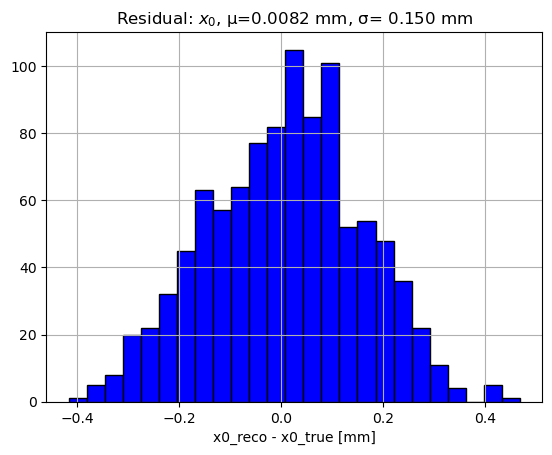

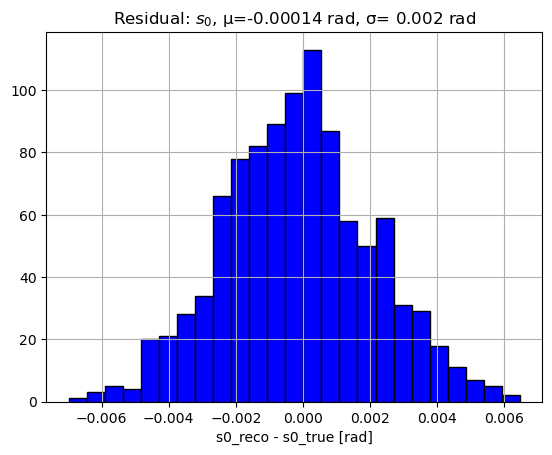

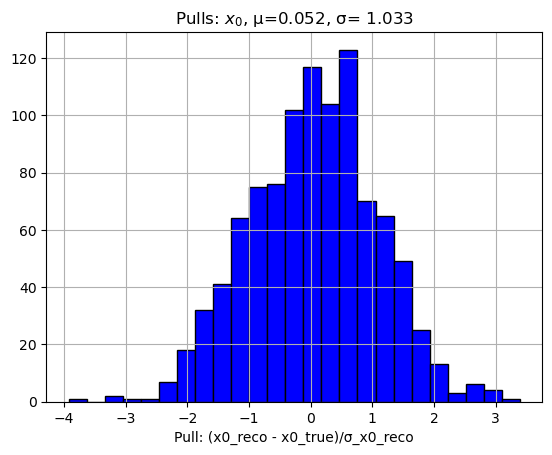

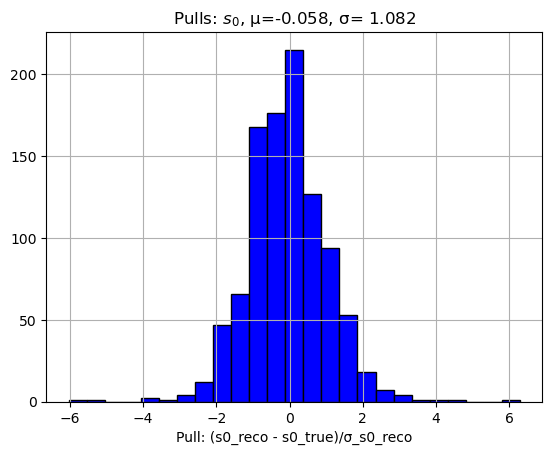

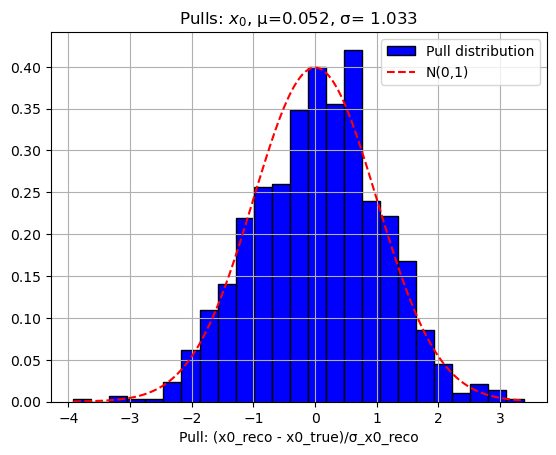

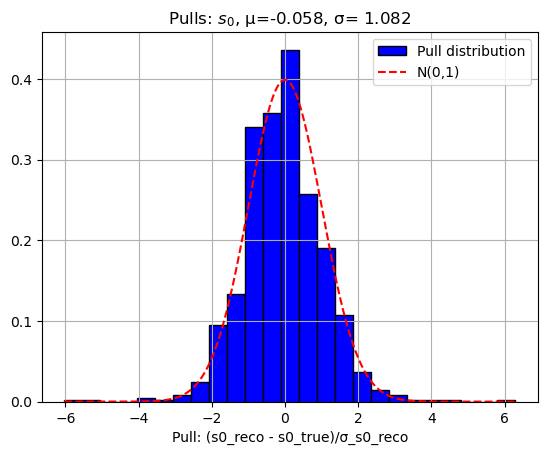

In [7]:
n_trajectories = 1000
z0 = 0
delta_z = 0.02  # 2 cm in metres
n_planes = 5
cell_width = 0.0005  # 500 micrometers in metres

# Calculate the uncertainty
std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia

z_positions = np.arange(1, n_planes + 1) * delta_z

def trajectory_fun_linear(z_position, x0, slope): 
    return x0 + z_position * slope # Calculating the vertical position using trigonometry

np.random.seed(42)

# Arrays for the residuals and for the pulls
resi_s0 = np.full(n_trajectories, np.nan)
resi_x0 = np.full(n_trajectories, np.nan)

pulls_s0 = np.full(n_trajectories, np.nan)
pulls_x0 = np.full(n_trajectories, np.nan)

for i in range(n_trajectories):
    x0_true = np.random.normal(0, 0.001)
    s0_true = np.random.normal(0, 0.1)

    slope_true = np.tan(s0_true)

    x_positions = trajectory_fun_linear(z_positions, x0_true, slope_true) 

    # Calculate which cell was hit
    cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
    cells_hit_middle = cells_hit * cell_width + cell_width / 2

    # Add Gaussian noise to simulate measurement uncertainty (realistic detector resolution)
    # Increases the uncertainty a lot - maybe not what we want
    # cells_hit_middle += np.random.normal(0, std_hit, size=cells_hit_middle.shape)

    # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
    popt, pcov = curve_fit(trajectory_fun_linear, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

    x0_reco, slope_reco = popt
    std_x0_reco, std_slope_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)

    s0_reco = np.arctan(slope_reco)

    # We now do error propagation by using y = f(x) -> sigma_y = abs(df/dx (x_mean)) * sigma_x
    std_s0_reco = std_slope_reco / (1 + slope_reco**2)

    resi_s0[i] = s0_reco - s0_true
    resi_x0[i] = x0_reco - x0_true

    # pull = (reconstructed_quantity - generated_quantity)/uncertainty_on_reconstructed_quantity
    pulls_s0[i] = (s0_reco - s0_true)/std_s0_reco
    pulls_x0[i] = (x0_reco - x0_true)/std_x0_reco


# Taking the mean and standard deviation for the residuals
mean_resi_s0 = np.mean(resi_s0)
mean_resi_x0 = np.mean(resi_x0)

std_resi_s0 = np.std(resi_s0)
std_resi_x0 = np.std(resi_x0)


# Plot these distributions as histograms
plt.figure()
plt.hist(resi_x0 * 1000, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $x_0$, μ={mean_resi_x0 * 1000:.4f} mm, σ={std_resi_x0 * 1000: .3f} mm")
plt.xlabel("x0_reco - x0_true [mm]")
plt.grid()
plt.show()

plt.figure()
plt.hist(resi_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $s_0$, μ={mean_resi_s0:.5f} rad, σ={std_resi_s0: .3f} rad")
plt.xlabel("s0_reco - s0_true [rad]")
plt.grid()
plt.show()


# Taking the mean and standard deviation for the pulls
mean_pulls_s0 = np.mean(pulls_s0)
mean_pulls_x0 = np.mean(pulls_x0)

std_pulls_s0 = np.std(pulls_s0)
std_pulls_x0 = np.std(pulls_x0)

# Plot these distributions as histograms
plt.figure()
plt.hist(pulls_x0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $x_0$, μ={mean_pulls_x0:.3f}, σ={std_pulls_x0: .3f}")
plt.xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
plt.grid()
plt.show()

plt.figure()
plt.hist(pulls_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $s_0$, μ={mean_pulls_s0:.3f}, σ={std_pulls_s0: .3f}")
plt.xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
plt.grid()
plt.show()

# Plot the distributions exactly the same way again, now with overlayed Gaussian distributions
plt.figure()
plt.hist(pulls_x0, bins=25, color="blue", edgecolor="black", density=True, label="Pull distribution")
x_vals = np.linspace(min(pulls_x0), max(pulls_x0), 500)
plt.plot(x_vals, norm.pdf(x_vals, loc=0, scale=1), 'r--', label="N(0,1)")
plt.title(f"Pulls: $x_0$, μ={mean_pulls_x0:.3f}, σ={std_pulls_x0: .3f}")
plt.xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.hist(pulls_s0, bins=25, color="blue", edgecolor="black", density=True, label="Pull distribution")
x_vals = np.linspace(min(pulls_s0), max(pulls_s0), 500)
plt.plot(x_vals, norm.pdf(x_vals, loc=0, scale=1), 'r--', label="N(0,1)")
plt.title(f"Pulls: $s_0$, μ={mean_pulls_s0:.3f}, σ={std_pulls_s0: .3f}")
plt.xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
plt.legend()
plt.grid()
plt.show()
    